In [1]:
#@title Run on TensorFlow 2.x
# %tensorflow_version 2.x

In [2]:
#@title Import relevant modules
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [3]:
colormap = {0:'black', 1:'red', 2:'blue'}
def plot_region(model,dlim,features=[]):
    d1lim = dlim[:2]
    d2lim = dlim[2:]
    d1_grid, d2_grid = np.meshgrid(np.arange(d1lim[0], d1lim[1], 0.02), np.arange(d2lim[0], d2lim[1], 0.02))
    X0 = d1_grid.ravel()
    X1 = d2_grid.ravel()
    
    d12_array = np.empty((len(X0),2+len(features)))
    d12_array[:,0] = X0
    d12_array[:,1] = X1
    i=2

    for feature in features:
        d12_array[:,i] = feature(X0,X1)
        i += 1
    
    y_array = model.predict(d12_array)
    y_grid = y_array.reshape(d1_grid.shape)
    plt.contourf(d1_grid, d2_grid, y_grid, cmap='Pastel2')

## Load the dataset

`tf.keras` provides a set of convenience functions for loading well-known datasets. Each of these convenience functions does the following:

* Loads both the training set and the test set.
* Separates each set into features and labels.

The relevant convenience function for MNIST is called `mnist.load_data()`:

In [4]:
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()


Notice that `mnist.load_data()` returned four separate values:

* `x_train` contains the training set's features.
* `y_train` contains the training set's labels.
* `x_test` contains the test set's features.
* `y_test` contains the test set's labels.

**Note:** The MNIST .csv training set is already shuffled.

## View the dataset

The .csv file for the California Housing Dataset contains column names (for example, `latitude`, `longitude`, `population`). By contrast, the .csv file for MNIST does not contain column names. Instead of column names, you use ordinal numbers to access different subsets of the MNIST dataset. In fact, it is probably best to think of `x_train` and `x_test` as three-dimensional NumPy arrays:  



In [5]:
# Output example #2917 of the training set.
x_train[2917]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 127, 100, 156, 239, 224, 177, 213, 159,  70,  13,   0,   0

Alternatively, you can call `matplotlib.pyplot.imshow` to interpret the preceding numeric array as an image. 

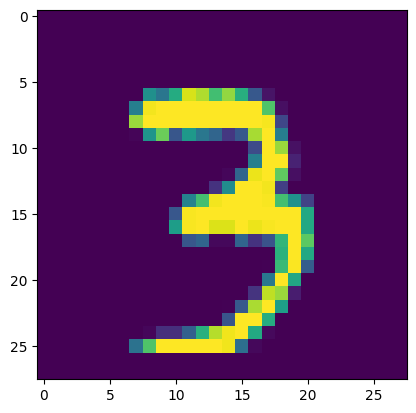

In [6]:
# Use false colors to visualize the array.
plt.imshow(x_train[2917])

In [7]:
# Output row #10 of example #2917.
x_train[2917][10]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  58, 254, 216,  11,   0,   0,   0,   0,   0,   0,   0,   0], dtype=uint8)

In [8]:
# Output pixel #16 of row #10 of example #2900.
x_train[2917][10][16]

58

## Task 1: Normalize feature values

Complete the following code cell to map each feature value from its current representation (an integer between 0 and 255) to a floating-point value between 0 and 1.0. Store the floating-point values in `x_train_normalized` and `x_test_normalized`.

In [9]:
#@title Double-click to see a solution to Task 1. 

x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
print(x_train_normalized[2900][10]) # Output a normalized row

[0.         0.         0.         0.         0.         0.         0.         0.55294118 1.         0.66666667 0.11372549 0.         0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.         0.         0.         0.         0.        ]


## Define a plotting function

The following function plots an accuracy curve:

In [10]:
#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.



#@title Define the plotting function
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

In [11]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs, batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size, epochs=epochs, shuffle=True, validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

## Invoke the previous functions

Run the following code cell to invoke the preceding functions and actually train the model on the training set. 

**Note:** Due to several factors (for example, more examples and a more complex neural network) training MNIST might take longer than training the California Housing Dataset. Be patient.

Epoch 1/50
12/12 [==============================] - 1s 17ms/step - loss: 1.7922 - accuracy: 0.4324 - val_loss: 1.0907 - val_accuracy: 0.7463
Epoch 2/50
12/12 [==============================] - 0s 8ms/step - loss: 0.9678 - accuracy: 0.7229 - val_loss: 0.5874 - val_accuracy: 0.8581
Epoch 3/50
12/12 [==============================] - 0s 8ms/step - loss: 0.6759 - accuracy: 0.8013 - val_loss: 0.4389 - val_accuracy: 0.8892
Epoch 4/50
12/12 [==============================] - 0s 8ms/step - loss: 0.5520 - accuracy: 0.8376 - val_loss: 0.3766 - val_accuracy: 0.9027
Epoch 5/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4858 - accuracy: 0.8585 - val_loss: 0.3364 - val_accuracy: 0.9114
Epoch 6/50
12/12 [==============================] - 0s 8ms/step - loss: 0.4462 - accuracy: 0.8691 - val_loss: 0.3111 - val_accuracy: 0.9177
Epoch 7/50
12/12 [==============================] - 0s 9ms/step - loss: 0.4086 - accuracy: 0.8814 - val_loss: 0.2903 - val_accuracy: 0.9220
Epoch 8/50
12/12 [=

[0.14962589740753174, 0.9559999704360962]

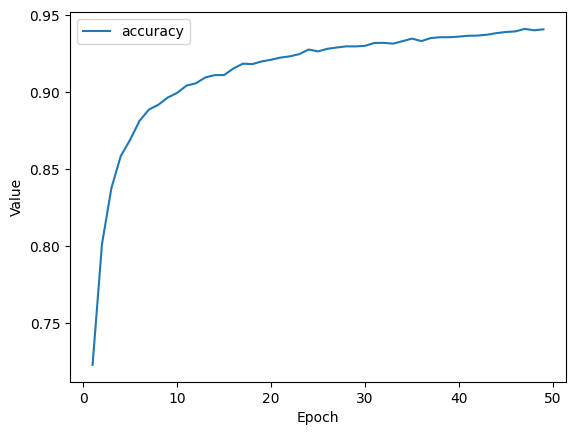

In [12]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 50
batch_size = 4000
validation_split = 0.2

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train_normalized, y_train, epochs, batch_size, validation_split)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test_normalized, y=y_test, batch_size=batch_size)

## Task 2: Optimize the model

Experiment with the following:

* number of hidden layers 
* number of nodes in each layer
* dropout regularization rate

What trends did you discover?  Can you reach at least 98% accuracy against the test set? 




In [13]:
#@title Double-click to view some possible answers.

# It would take much too long to experiment 
# fully with topography and dropout regularization 
# rate. In the real world, you would
# also experiment with learning rate, batch size, 
# and number of epochs.  Since you only have a 
# few minutes, searching for trends can be helpful.
# Here is what we discovered:
#   * Adding more nodes (at least until 256 nodes) 
#     to the first hidden layer improved accuracy.
#   * Adding a second hidden layer generally 
#     improved accuracy.
#   * When the model contains a lot of nodes, 
#     the model overfits unless the dropout rate 
#     is at least 0.5. 

# We reached 98% test accuracy with the 
# following configuration:
#   * One hidden layer of 256 nodes; no second 
#     hidden layer.
#   * dropout regularization rate of 0.4

# We reached 98.2% test accuracy with the 
# following configuration:
#   * First hidden layer of 256 nodes; 
#     second hidden layer of 128 nodes.
#   * dropout regularization rate of 0.2
